In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import collections




import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    log_loss,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     train_test_split,
                                     KFold,
                                     StratifiedShuffleSplit,
                                     RepeatedStratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from gauss_rank_scaler import GaussRankScaler

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

def outliers(data): # Функция для работы с выбросами
    quantiles = np.percentile(data, [25, 75])
    iqr = quantiles[1] - quantiles[0]
    left = quantiles[0] - 1.5 * iqr
    right = quantiles[1] + 1.5 * iqr
    return left, right
    
    
    
def ohe(train, test, column): # One-hot encoding
    test['default'] = None
    full = pd.concat([train, test], axis=0)
    dummies = pd.get_dummies(full[[column]], prefix=column, drop_first=True)
    full = pd.concat([full, dummies], axis=1).drop(columns=column)
    train = full[:train.shape[0]]
    test = full[train.shape[0]:]
    test = test.drop(columns=['default'])
    return train, test

def std_scale(train, test, column): #нормализация
    scaler = StandardScaler()
    train[column] = scaler.fit_transform(train[[column]])
    test[column] = scaler.transform(test[[column]])
    
    return train, test


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [3]:
train_1 = pd.read_csv('Project_NO/train.csv')
test_1 = pd.read_csv('Project_NO/test.csv')
sample_submission = pd.read_csv('Project_NO/sample_submission.csv')

In [4]:
train = train_1.copy()
test = test_1.copy()

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Посмотрим на тип данных и количество пропусков.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

Пропуски встречаются только в информации об образовании клиентов. 

## FEATURE ENGINEERING

In [7]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = [
    'education', 'home_address', 'work_address', 'sna', 'first_time', 
]
num_cols = [
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'region_rating'
]

## Преобразование бинарных и категориальных переменных

## client_id

In [8]:
train.client_id.value_counts()

6141     1
42113    1
29467    1
19228    1
21279    1
        ..
46588    1
48637    1
42494    1
87552    1
2049     1
Name: client_id, Length: 73799, dtype: int64

Все id уникальны. Так как client_id не несёт смысловой нагрузки и не участвует в обучении модели, можем этот признак исключить.

In [9]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

## app_date

Переведём даты в удобный формат.

In [10]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head(5))
print(test.app_date.head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


In [11]:
train.app_date.dt.month_name().value_counts()

March       21178
February    18028
April       17683
January     16910
Name: app_date, dtype: int64

Создадим новый признак по месяцу.

In [12]:
train['month'] = train['app_date'].dt.month
test['month'] = test['app_date'].dt.month

train = pd.get_dummies(train, columns=['month'], drop_first=True)
test = pd.get_dummies(test, columns=['month'], drop_first=True)

Посмотрим распределение по дням недели и так же сделаем признак.

In [13]:
train.app_date.dt.day_name().value_counts()

Tuesday      12176
Monday       12024
Wednesday    11740
Thursday     11615
Friday       11263
Saturday      8231
Sunday        6750
Name: app_date, dtype: int64

In [14]:
#train['weekday'] = train['app_date'].dt.dayofweek

#test['weekday'] = test['app_date'].dt.dayofweek

#train = pd.get_dummies(train, columns=['weekday'], drop_first=True)
#test = pd.get_dummies(test, columns=['weekday'], drop_first=True)

С датами мы закончили, столбец удаляем. Параметр weekday не повлиял на улучшение модели, его не будем использовать.

In [15]:
train.drop(columns=['app_date'], inplace=True)
test.drop(columns=['app_date'], inplace=True)

In [16]:
train.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'month_2', 'month_3',
       'month_4'],
      dtype='object')

## education

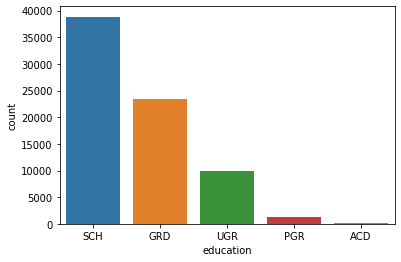

In [17]:
sns.countplot(train['education'])

Можем сделать вывод, что большая часть заёмщиков имеет образование SCH. Заполним пропуски модой.

In [18]:
education_1 = collections.Counter(train['education'])
education_2 = collections.Counter(test['education'])

train['education'].fillna(education_1.most_common()[0][0], inplace=True)
test['education'].fillna(education_2.most_common()[0][0], inplace=True)

In [19]:
train.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'month_2', 'month_3',
       'month_4'],
      dtype='object')

Применим One-hot encoding для категориальных и бинарных признаков

In [20]:
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month_2,month_3,month_4
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1,0,0
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,0,1,0
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1,0,0
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,0,0,0
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,0,0,1


In [21]:
for col in ['education', 'sex', 'car', 'car_type', 'good_work', 'foreign_passport']: 
    train, test = ohe(train, test, col)

In [22]:
train.columns

Index(['client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'default', 'month_2', 'month_3', 'month_4',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'sex_M', 'car_Y', 'car_type_Y', 'foreign_passport_Y'],
      dtype='object')

In [23]:
train.head()

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,month_2,month_3,month_4,education_GRD,education_PGR,education_SCH,education_UGR,sex_M,car_Y,car_type_Y,foreign_passport_Y
0,25905,62,0,-2.008753,1,50,1,2,18000,4,1,0,1,0,0,0,0,1,0,1,1,1,0
1,63161,59,0,-1.532276,3,50,2,3,19000,4,1,0,0,1,0,0,0,1,0,0,0,0,0
2,25887,25,2,-1.408142,1,80,1,2,30000,1,4,0,1,0,0,0,0,1,0,1,1,0,1
3,16222,53,0,-2.057471,2,50,2,3,10000,1,3,0,0,0,0,0,0,1,0,0,0,0,0
4,101655,48,0,-1.244723,1,60,2,3,30000,1,4,0,0,0,1,1,0,0,0,1,0,0,1


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           73799 non-null  int64  
 1   age                 73799 non-null  int64  
 2   decline_app_cnt     73799 non-null  int64  
 3   score_bki           73799 non-null  float64
 4   bki_request_cnt     73799 non-null  int64  
 5   region_rating       73799 non-null  int64  
 6   home_address        73799 non-null  int64  
 7   work_address        73799 non-null  int64  
 8   income              73799 non-null  int64  
 9   sna                 73799 non-null  int64  
 10  first_time          73799 non-null  int64  
 11  default             73799 non-null  object 
 12  month_2             73799 non-null  uint8  
 13  month_3             73799 non-null  uint8  
 14  month_4             73799 non-null  uint8  
 15  education_GRD       73799 non-null  uint8  
 16  educ

## default

Оценим распределение целевой переменной - default. 

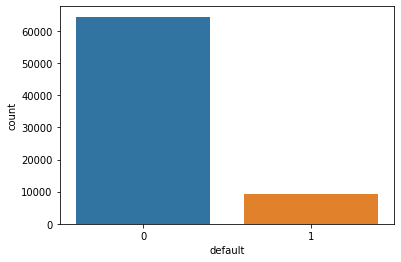

In [25]:
sns.countplot(x='default', data=train)

Распределение неравномерно, поробуем это поправить с помощью oversampling.

In [26]:
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)  

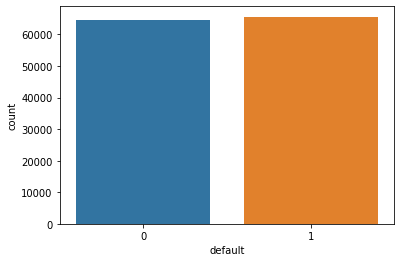

In [27]:
sns.countplot(x='default', data=train)

In [28]:
train.columns

Index(['client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'default', 'month_2', 'month_3', 'month_4',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'sex_M', 'car_Y', 'car_type_Y', 'foreign_passport_Y'],
      dtype='object')

Посмотрим на числовые признаки

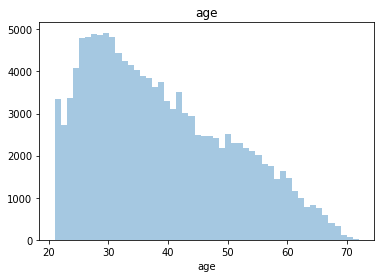

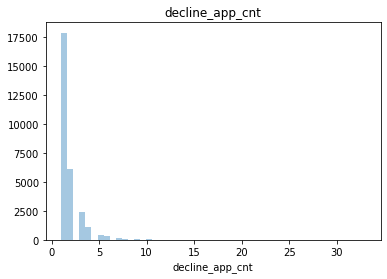

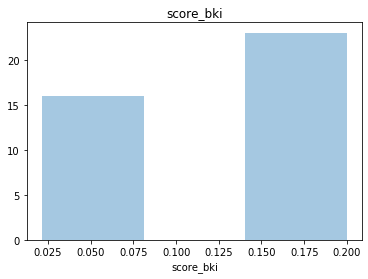

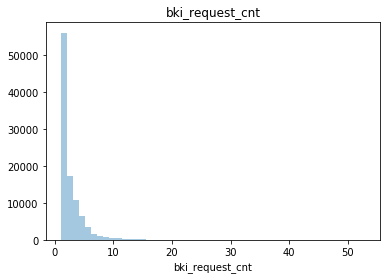

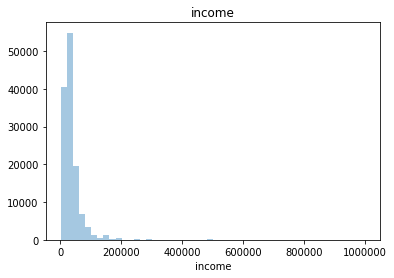

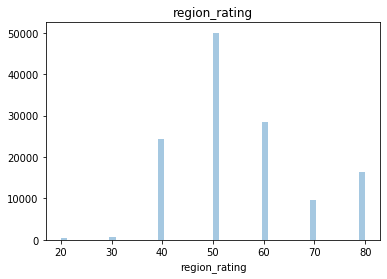

In [29]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

## ВЫБРОСЫ

Для оценки выбросов посмотрим на числовые признаки - age, decline_app_cnt, bki_request_cnt, income, region_rating.

## age

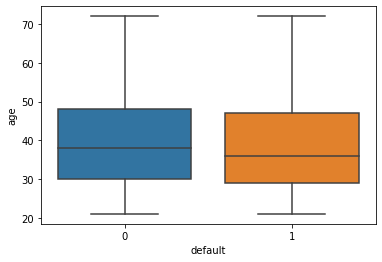

In [30]:
sns.boxplot(x=train.default, y=train.age)

В среднем видим, что дефолтные клиенты младше. Выбросов нет.

## decline_app_cnt

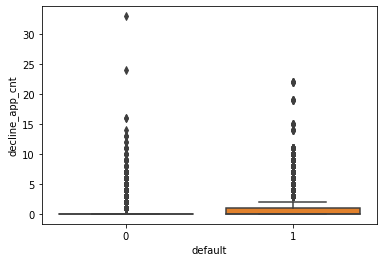

In [31]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных. Есть выбросы, но удалять их не стоит, т.к. медиана у равна практически 0.

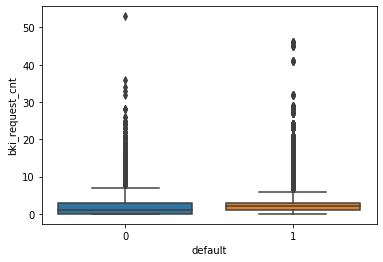

In [32]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

Выбросы есть, надо убирать.

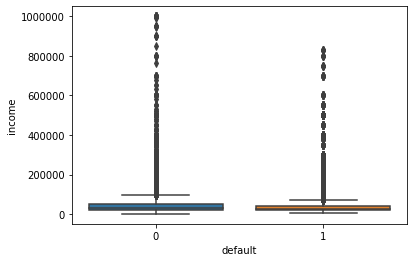

In [33]:
sns.boxplot(x=train.default, y=train.income)

Выбросы есть, надо убирать.

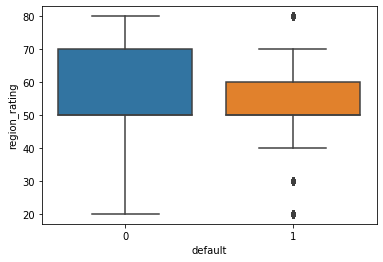

In [34]:
sns.boxplot(x=train.default, y=train.region_rating)

Удалим выбросы.

In [35]:
num_cols_1 = ['bki_request_cnt', 'score_bki'] #Удаление выбросов только двух параметров оказало положительное влияние на модель
for colname in num_cols_1:
    d = outliers(train[colname])
    train = train.loc[train[colname].between(d[0], d[1])]

In [36]:
train.head()

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,month_2,month_3,month_4,education_GRD,education_PGR,education_SCH,education_UGR,sex_M,car_Y,car_type_Y,foreign_passport_Y
0,25905,62,0,-2.008753,1,50,1,2,18000,4,1,0,1,0,0,0,0,1,0,1,1,1,0
1,63161,59,0,-1.532276,3,50,2,3,19000,4,1,0,0,1,0,0,0,1,0,0,0,0,0
2,25887,25,2,-1.408142,1,80,1,2,30000,1,4,0,1,0,0,0,0,1,0,1,1,0,1
3,16222,53,0,-2.057471,2,50,2,3,10000,1,3,0,0,0,0,0,0,1,0,0,0,0,0
4,101655,48,0,-1.244723,1,60,2,3,30000,1,4,0,0,0,1,1,0,0,0,1,0,0,1


## Посмотрим на графики распределения числовых переменных:

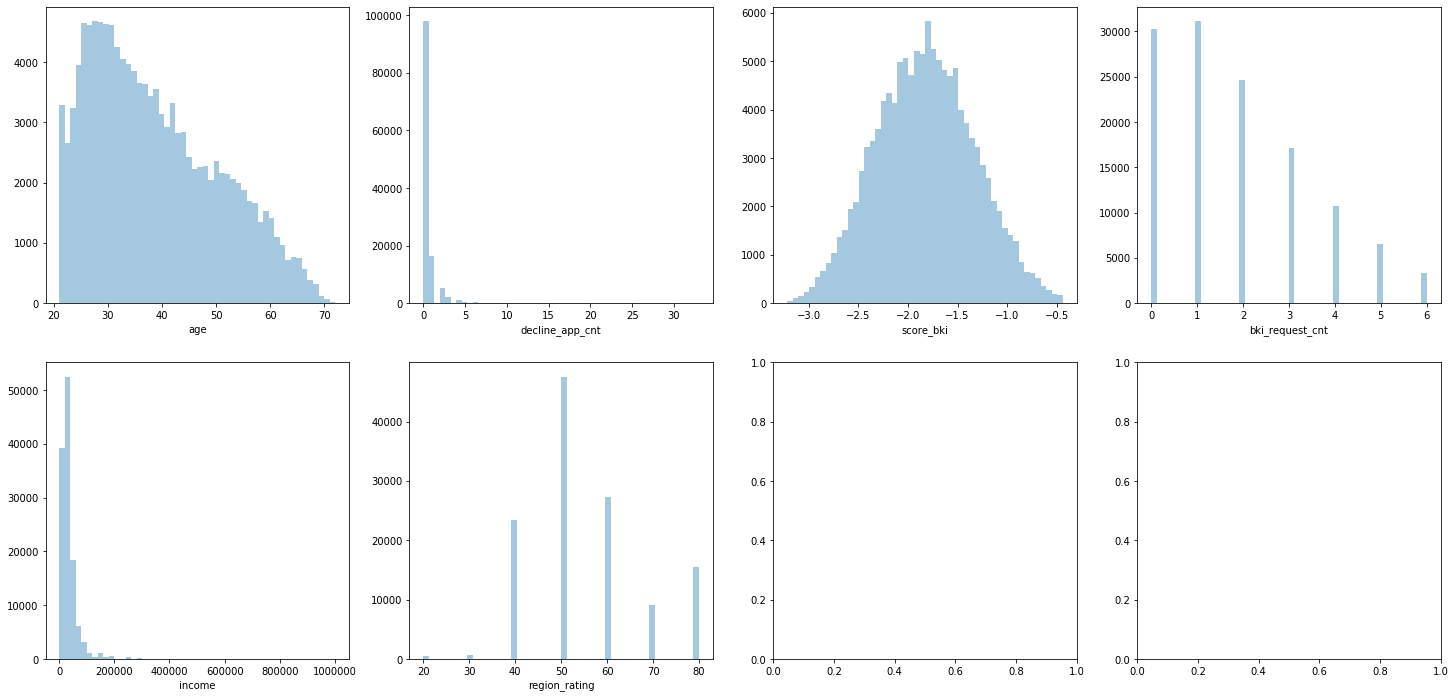

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [38]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

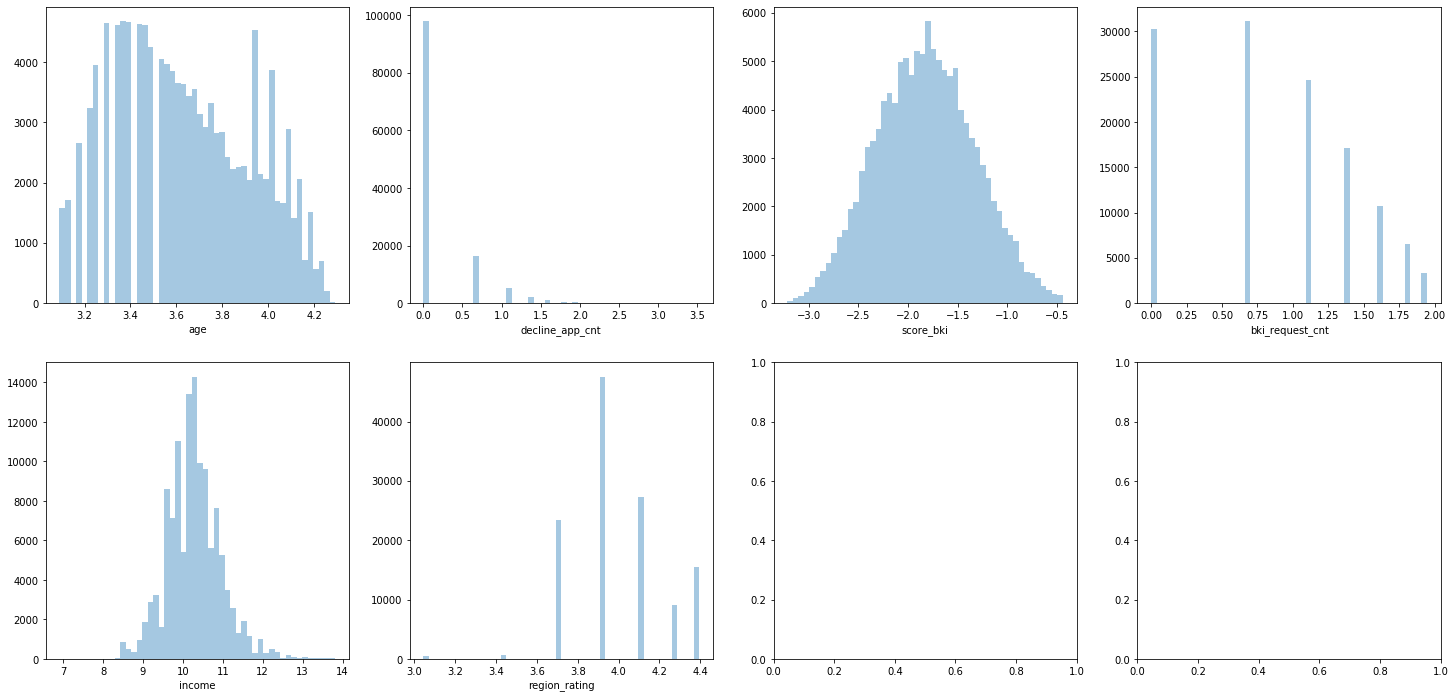

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [40]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

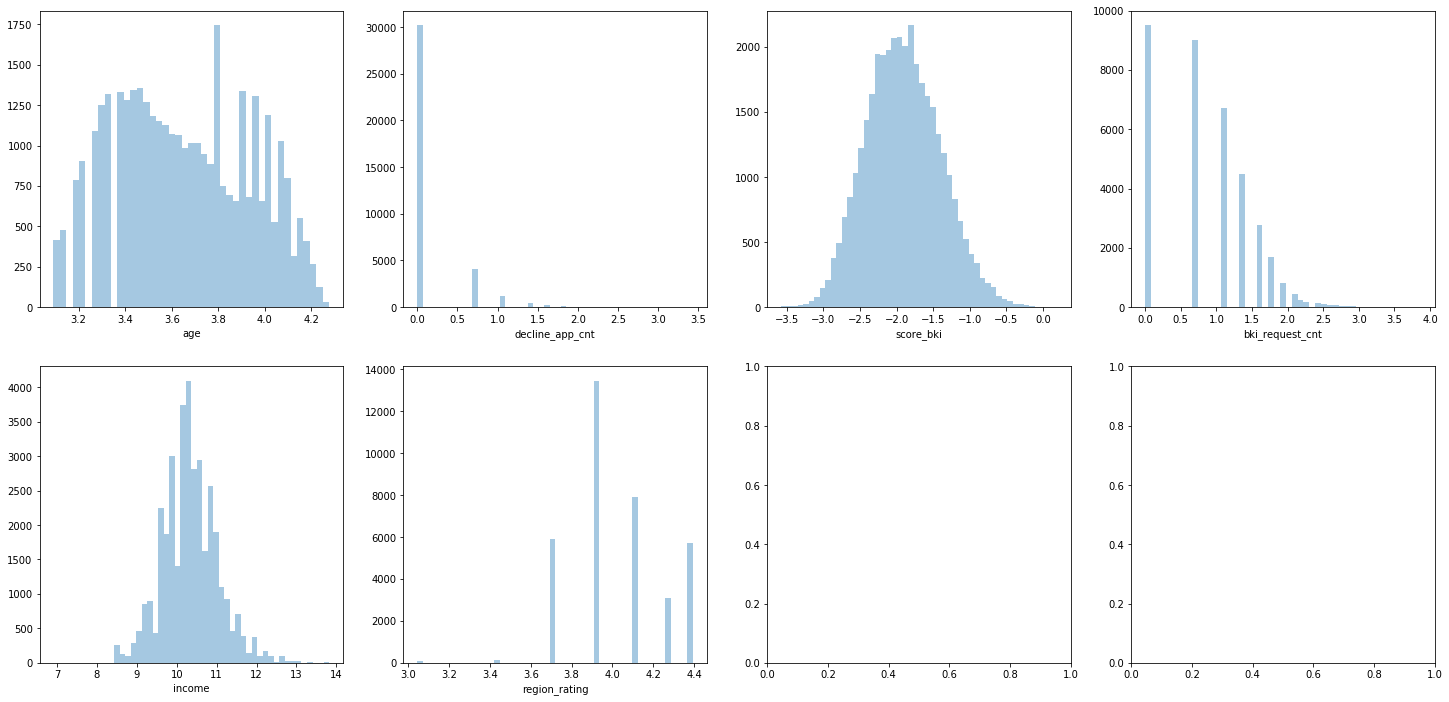

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(test[col], kde=False, ax=axes.flat[i])

## Нормализация

In [42]:
for col in ['income', 'bki_request_cnt', 'decline_app_cnt', 'age', 
            'region_rating', 'sna', 'home_address', 'work_address', 'first_time']:
     train, test = std_scale(train, test, col)

In [43]:
train.head()

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,month_2,month_3,month_4,education_GRD,education_PGR,education_SCH,education_UGR,sex_M,car_Y,car_type_Y,foreign_passport_Y
0,25905,1.742479,-0.471767,-2.008753,-0.295556,-0.335276,-1.206993,-0.847573,-0.729141,1.750563,-1.596601,0,1,0,0,0,0,1,0,1,1,1,0
1,63161,1.572038,-0.471767,-1.532276,0.854074,-0.335276,0.724446,0.671566,-0.648903,1.750563,-1.596601,0,0,1,0,0,0,1,0,0,0,0,0
2,25887,-1.349271,2.273145,-1.408142,-0.295556,1.746007,-1.206993,-0.847573,0.028956,-0.742571,1.320489,0,1,0,0,0,0,1,0,1,1,0,1
3,16222,1.203977,-0.471767,-2.057471,0.376935,-0.335276,0.724446,0.671566,-1.601426,-0.742571,0.348126,0,0,0,0,0,0,1,0,0,0,0,0
4,101655,0.864550,-0.471767,-1.244723,-0.295556,0.470239,0.724446,0.671566,0.028956,-0.742571,1.320489,0,0,0,1,1,0,0,0,1,0,0,1


In [44]:
train.drop(columns=['client_id'], axis=0, inplace=True)
test.drop(columns=['client_id'], axis=0, inplace=True)


In [45]:
train.shape


(123736, 22)

In [46]:
test.shape


(36349, 21)

## Model_training

In [47]:
X = train.drop(columns='default').values
y = train.default.values.astype(int)

In [48]:
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-2, 2, 10),
}

In [49]:
s = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

In [50]:
train_ind, val_ind = list(s.split(X, y))[0]

In [51]:
X_train, X_val, y_train, y_val = X[train_ind], X[val_ind], y[train_ind], y[val_ind]

In [52]:
param_grid.update({'class_weight': ['balanced', {0: 1, 1: 10}]})

In [53]:
param_grid

{'penalty': ['l2'],
 'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
        5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
        3.59381366e+01, 1.00000000e+02]),
 'class_weight': ['balanced', {0: 1, 1: 10}]}

In [54]:
stratified_cv = RepeatedStratifiedKFold(n_repeats=2, random_state=RANDOM_SEED)

In [55]:
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
gs = GridSearchCV(logreg, param_grid=param_grid, cv=stratified_cv, scoring='roc_auc')

In [56]:
gs.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'class_weight': ['balanced', {0: 1, 1: 10}],
                         'penalty': ['l2']},
             scoring='roc_auc')

In [57]:
gs.best_params_

{'C': 0.5994842503189409, 'class_weight': 'balanced', 'penalty': 'l2'}

In [58]:
probs = gs.predict_proba(X_val)
preds = gs.predict(X_val)
print('ROC AUC', roc_auc_score(y_val, probs[:, 1]))
print()
print('Confusion matrix: \n', confusion_matrix(y_val, preds))

ROC AUC 0.7319897540443985

Confusion matrix: 
 [[8263 4169]
 [3986 8330]]


In [59]:
probs = gs.predict_proba(test)
probs = probs[:, 1]

In [60]:
test['client_id'] = test_1['client_id']

In [61]:
client_id = test['client_id']

In [62]:
my_submission = pd.DataFrame({'client_id': client_id,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.sample(10)

,client_id,default
34709,90067,0.426151
6279,27716,0.232969
8679,93571,0.334074
2865,80676,0.741266
6090,56688,0.485453
5137,46243,0.224577
12077,71768,0.476336
10748,109977,0.645701
10014,79528,0.622443
33949,72943,0.101317


## ВЫВОДЫ

По итогам работы с данными можно сделать вывод, что наиболее сильное влияние на силу предсказания оказывает EDA и Feature Engeneering. Тем не менее, логарифмирование и нормализция также оказали положительное влияние на модель.